<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_DDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.gluon as gluon
from mxnet.gluon.loss import L2Loss
import numpy as np
from mxnet import init
import mxnet.gluon.nn as nn
import gym
import matplotlib.pyplot as plt

# Hyper params

In [0]:
BATCH_SIZE = 256          
LR = 0.001                                                       
EPSILON = 0.95                                                
GAMMA = 0.95                             
TARGET_REPLACE_ITER = 1000                          
MEMORY_CAPACITY = 10000
param_path = './param_path'
l2loss = L2Loss(batch_axis=0)

# env

In [0]:
env = gym.make('CartPole-v0')                 
N_ACTIONS=env.action_space.n                       
N_STATES = env.observation_space.shape[0]    

# Q_net

In [0]:
def build_Q_net(net,num_actions):
  with net.name_scope():
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(num_actions))
  return net

In [0]:
state = nd.random.normal(shape=(1,4))

In [6]:
q = build_Q_net(nn.HybridSequential(),N_ACTIONS)
q.initialize(init=init.Xavier(),force_reinit=True)
q(state)


[[-0.20866524 -0.40591076]]
<NDArray 1x2 @cpu(0)>

# copy params

In [7]:
q1 = build_Q_net(nn.HybridSequential(),N_ACTIONS)
q1.initialize(init=init.Xavier())
q2 = build_Q_net(nn.HybridSequential(),N_ACTIONS)
q2.initialize(init=init.Xavier())

# same
print(q1(state))
print(q2(state))

# copy params
q1.save_parameters(param_path)
q2.load_parameters(param_path)

# different
print(q1(state))
print(q2(state))


[[-0.31712627  0.0712393 ]]
<NDArray 1x2 @cpu(0)>

[[ 0.169029   -0.11568238]]
<NDArray 1x2 @cpu(0)>

[[-0.31712627  0.0712393 ]]
<NDArray 1x2 @cpu(0)>

[[-0.31712627  0.0712393 ]]
<NDArray 1x2 @cpu(0)>


# memory

In [8]:
s = [1,1]
r = 1
a = 1
d = 1
s_ = [1,1]
transition = np.hstack((s,[a,r,d],s_))
transition

array([1, 1, 1, 1, 1, 1, 1])

# class DQN

In [0]:
class DQN(object):
  def __init__(self,N_ACTIONS):
    # eval_net
    self.eval_net = build_Q_net(nn.HybridSequential(),N_ACTIONS)
    self.eval_net.initialize(init=init.Xavier()) # same with target_net
    
    # target_net
    self.target_net = build_Q_net(nn.HybridSequential(),N_ACTIONS)
    self.target_net.initialize(init=init.Xavier())# same with eval_net
    
    # init forward
    random_x=nd.random_uniform(shape=(1,N_STATES))
    _ = self.eval_net(random_x)
    _ = self.target_net(random_x)

    # init copy params
    self.eval_net.save_parameters(param_path)
    self.target_net.load_parameters(param_path)

    # memory
    self.memory_counter = 0
    self.memory = np.zeros(shape=(MEMORY_CAPACITY, N_STATES*2 + 3)) # state,[action,reward ,done],next_state N_STATES*2 +3
    
    # trainer
    self.trainer = gluon.Trainer(self.eval_net.collect_params(),'Adam',{'learning_rate':LR})

    # record history
    self.learn_step_counter = 0
    self.cost_his=[]
  
  def choose_action(self,x):
    # select best action
    if np.random.uniform() < EPSILON:
      x = nd.array([x])
      action_value = self.eval_net(x)
      action = nd.argmax(action_value,axis=1).asscalar()
      return int(action)
    # select random action
    else:
      return np.random.randint(0,N_ACTIONS)
  
  def store_transition(self,s,a,r,d,s_):
    # add transition to memory
    transition = np.hstack((s,[a,r,d],s_))
    index = self.memory_counter % MEMORY_CAPACITY
    self.memory[index,:] = transition
    self.memory_counter += 1
  
  def learn(self):
    # record how many times of eval_net update
    self.learn_step_counter += 1

    # update target_net every TARGET_REPLACE_ITER
    if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
      print('copy params to target_net')
      self.eval_net.save_parameters(param_path)
      self.target_net.load_parameters(param_path)
    
    # from memory sample a mini_batch_data
    sample_index = np.random.choice(MEMORY_CAPACITY,BATCH_SIZE)
    b_memory = self.memory[sample_index,:]
    b_s = nd.array(b_memory[:,:N_STATES])
    b_a = nd.array(b_memory[:,N_STATES:N_STATES+1])
    b_r = nd.array(b_memory[:,N_STATES+1:N_STATES+2])
    b_r = nd.squeeze(b_r)
    b_d = nd.array(b_memory[:,N_STATES+2:N_STATES+3])
    b_d = nd.squeeze(b_d)
    b_s_= nd.array(b_memory[:,-N_STATES:])
    
    # caculate gradient
    with mx.autograd.record():
      # 1.target_net input b_s_(next_state) output q_sp
      Q_sp = nd.max(self.target_net(b_s_),axis=1) # the max next_q_value
      Q_sp = Q_sp * (nd.ones(BATCH_SIZE) - b_d) # if is done not have Q_sp
      # 2.eval_net input b_s(state) output q_s_array
      Q_s_array = self.eval_net(b_s) # Q_s_array
      Q_s = nd.pick(Q_s_array,b_a,1) # the choose action's q_value
      # count l2_loss
      loss = nd.mean(l2loss(Q_s,(b_r + GAMMA*Q_sp)))
    
    # loss backward and trainer step
    loss.backward()
    self.trainer.step(BATCH_SIZE)
    
    # record loss history
    self.cost_his.append(nd.mean(loss).asscalar())
  
  def plot_cost(self):
     plt.plot(np.arange(len(self.cost_his)), self.cost_his)
     plt.ylabel('Cost')
     plt.xlabel('training steps')
     plt.show()

In [10]:
all_rewards = []
avg_rewards = []
dqn = DQN(N_ACTIONS)
for episode in range(1000):
  s = env.reset()
  rewards = []
  while True:
    # choose action
    a = dqn.choose_action(s)
    # do action on env
    s_ ,r ,done ,info = env.step(a)
    # store
    rewards.append(r) 
    dqn.store_transition(s,a,r,int(done),s_)
    # if have collect a lot of memory can learn
    if dqn.memory_counter > BATCH_SIZE:
      dqn.learn()
    # if env done
    if done:
      break
    # if env not done
    else:
      s = s_
  # record this episode infomation 
  all_rewards.append(np.sum(rewards))
  avg_rewards.append(np.mean(all_rewards[-10:]))
  if episode % 10 == 0:
    print(episode,avg_rewards[-1:])
  if (all_rewards[-1] >= 200)&(avg_rewards[-1] >= 195):
    print(episode,all_rewards[-1],avg_rewards[-1])
    break

0 [93.0]
10 [26.3]
20 [20.0]
30 [14.3]
40 [13.6]
50 [11.7]
60 [11.6]
70 [11.3]
copy params to target_net
80 [14.3]
90 [10.7]
100 [10.8]
110 [12.5]
120 [12.1]
130 [10.0]
140 [10.8]
150 [10.8]
160 [10.5]
copy params to target_net
170 [15.3]
180 [14.2]
190 [14.3]
200 [19.9]
210 [17.0]
copy params to target_net
220 [26.2]
230 [36.6]
240 [55.7]
copy params to target_net
250 [76.6]
copy params to target_net
260 [91.3]
copy params to target_net
270 [86.1]
copy params to target_net
280 [103.3]
copy params to target_net
290 [107.2]
copy params to target_net
300 [128.9]
copy params to target_net
copy params to target_net
310 [147.6]
copy params to target_net
320 [162.5]
copy params to target_net
copy params to target_net
330 [190.7]
copy params to target_net
copy params to target_net
340 [189.4]
copy params to target_net
copy params to target_net
348 200.0 198.8


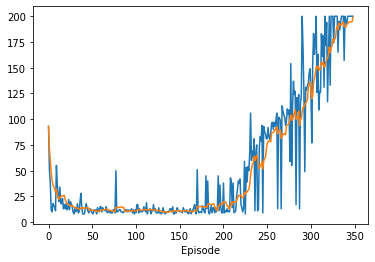

In [11]:
plt.plot(all_rewards)
plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.show()

# TEST

In [18]:
all_rewards = []
for episode in range(10):
  s = env.reset()
  rewards = []
  while True:
    a = dqn.choose_action(s)
    s_ ,r ,done ,info = env.step(a)
    rewards.append(r) 
    if done:
      break
    s = s_ 
  all_rewards.append(np.sum(rewards))
  print(episode,'score',all_rewards[-1:])

0 score [171.0]
1 score [164.0]
2 score [159.0]
3 score [160.0]
4 score [141.0]
5 score [143.0]
6 score [153.0]
7 score [143.0]
8 score [167.0]
9 score [171.0]
